In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.filters as filters
import skimage.exposure as exposure
from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature
import skimage.segmentation as seg

In [16]:
def processing(img):
    # img = cv2.resize(img, (500, 500))
    # green channel
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mg = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
    reverse = cv2.bitwise_not(mg)
    contours, hierarchy = cv2.findContours(reverse, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    select = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(select)
    png = img[y:y+h, x:x+w]
    # png = cv2.resize(png, (500, 500))
    green = png[:, :, 1]
    clahe = exposure.equalize_adapthist(green, clip_limit=0.03)
    canny = feature.canny(clahe, sigma=2.0, low_threshold=0.05, high_threshold=0.1)
    # flood filling
    flood = seg.flood_fill(canny, (1, 1), 255, connectivity=2)

    return flood

In [45]:
import cv2
import numpy as np

# read the image
# img = cv2.imread('retina_eye.jpg')

def blood(img):
    # convert to GREEN
    gray = img[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (5,5))
    morph = cv2.morphologyEx(gray, cv2.MORPH_DILATE, kernel)

    # divide gray by morphology image
    division = cv2.divide(gray, morph, scale=255)

    # threshold
    thresh = cv2.threshold(division, 0, 255, cv2.THRESH_OTSU )[1] 

    # invert
    thresh = 255 - thresh

    # find contours and discard contours with small areas
    mask = np.zeros_like(thresh)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    area_thresh = 10000
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > area_thresh:
            cv2.drawContours(mask, [cntr], -1, 255, 2)

    # apply mask to thresh
    result1 = cv2.bitwise_and(thresh, mask)
    mask = cv2.merge([mask,mask,mask])
    result2 = cv2.bitwise_and(img, mask)
    return result2

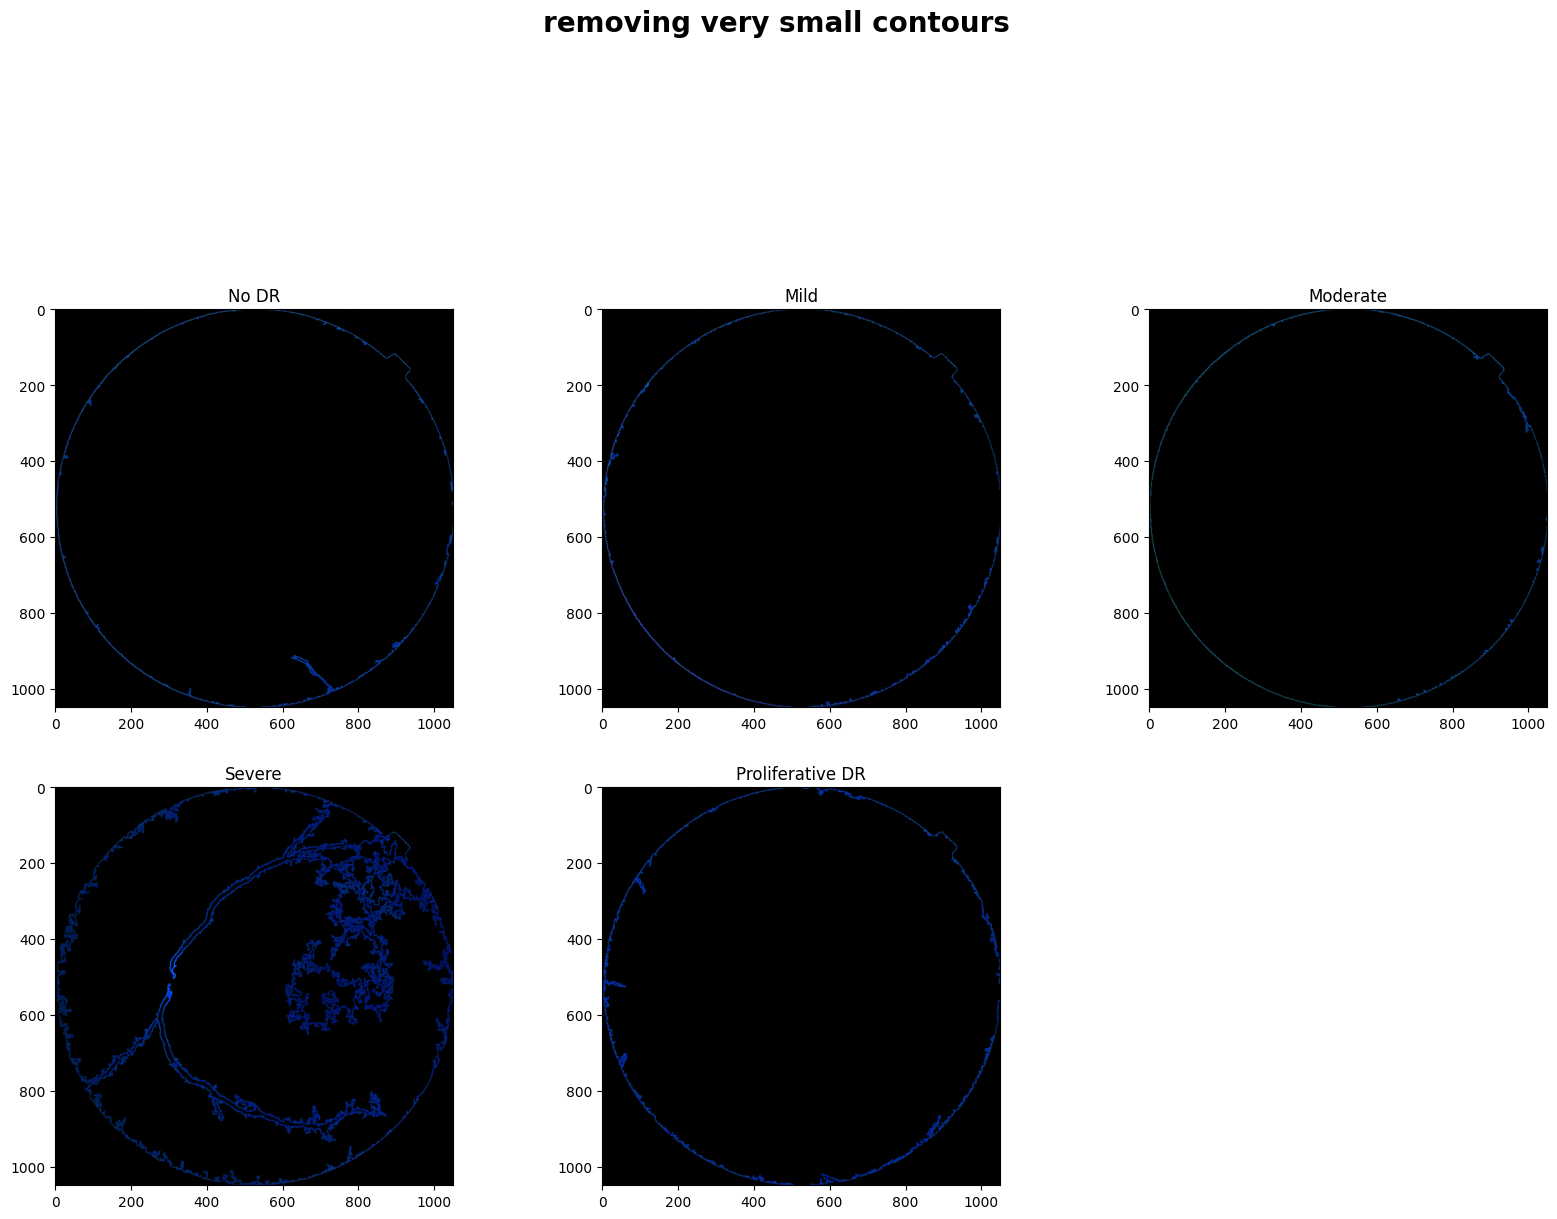

In [46]:
img0 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/0/00cc2b75cddd.png')
img1 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/1/38e0e28d35d3.png')
img2 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/2/3f5b4c2948e8.png')
img3 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/3/8688f3d0fcaf.png')
img4 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/4/613028ede6a0.png')

# img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
# img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

img0 = blood(img0)
img1 = blood(img1)
img2 = blood(img2)
img3 = blood(img3)
img4 = blood(img4)

# cv2.imshow('img0', img0)
# cv2.imshow('img1', img1)
# cv2.imshow('img2', img2)
# cv2.imshow('img3', img3)
# cv2.imshow('img4', img4)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.figure(figsize=(20, 30))
plt.suptitle('removing very small contours', fontsize=20, fontweight='bold')
plt.subplot(5, 3, 1)
plt.title('No DR')
plt.imshow(img0, cmap='gray')
plt.subplot(5, 3, 2)
plt.title('Mild')
plt.imshow(img1, cmap='gray')
plt.subplot(5, 3, 3)
plt.title('Moderate')
plt.imshow(img2, cmap='gray')
plt.subplot(5, 3, 4)
plt.title('Severe')
plt.imshow(img3, cmap='gray')
plt.subplot(5, 3, 5)
plt.title('Proliferative DR')
plt.imshow(img4, cmap='gray')

cv2.imshow('result2', img4)  
cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
def glcm(img):
    glcm_feature = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    distance = [5]
    angles = [0]
    level = 256
    symetric = True
    normed = True

    glcm = graycomatrix(img, distance, angles, level, symmetric=symetric, normed=normed)
    glcm_props = [property for name in glcm_feature for property in graycoprops(glcm, name)[0]]

    return glcm_props

In [19]:
glcm0 = glcm(img0)
glcm1 = glcm(img1)
glcm2 = glcm(img2)
glcm3 = glcm(img3)
glcm4 = glcm(img4)

print(glcm0)
print(glcm1)
print(glcm2)
print(glcm3)
print(glcm4)

[0.00010571884256094783, 0.00010571884256094783, 0.9999471405787196, 0.9997885790795885, 0.9998942839518529, -5.286221554659531e-05]
[0.0002734107997265892, 0.0002734107997265892, 0.9998632946001368, 0.9994532905307449, 0.9997266078937506, -0.0001367240907847963]
[0.00018045112781954887, 0.00018045112781954887, 0.9999097744360902, 0.9996227450350851, 0.9998113547240225, 0.08324309888783767]
[0.0001751505199781062, 0.0001751505199781062, 0.9999124247400111, 0.999646096653211, 0.9998230326678872, 0.020320580175411208]
[0.00015873015873015873, 0.00015873015873015873, 0.9999206349206349, 0.9996716323654576, 0.9998358027023525, 0.06443675721910477]
